In [1]:
import json
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import mplhep as mh

from hist.hist import Hist
from hist.axis import Regular
from hist.axis import IntCategory
from hist.axis import StrCategory

from pathlib import Path

from typing import Optional, Union

from matplotlib.colors import Colormap, ListedColormap
from matplotlib.colors import LogNorm

In [2]:
from functools import cache
from functools import cached_property

@cache
def get_segment(ring: int, station: int, sector: int, subsector: int) -> int:
    """
    https://github.com/cms-sw/cmssw/blob/CMSSW_13_3_0_pre3/Geometry/RPCGeometry/src/RPCGeomServ.cc#L361-L368
    """
    nsub = 3 if ring == 1 and station > 1 else 6
    return subsector + nsub * (sector - 1)


@cache
def get_roll_name(region: int, ring: int, station: int, sector: int, layer: int,
             subsector: int, roll: int
) -> str:
    """
    https://github.com/cms-sw/cmssw/blob/CMSSW_13_3_0_pre3/Geometry/RPCGeometry/src/RPCGeomServ.cc#L11-L87
    """
    if region == 0:
        name = f'W{ring:+d}_RB{station}'

        if station <= 2:
            name += 'in' if layer == 1 else 'out'
        else:
            if sector == 4 and station == 4:
                name += ['--', '-', '+', '++'][subsector - 1]
            elif (station == 3) or (station == 4 and sector not in (4, 9, 11)):
                name += '-' if subsector == 1 else '+'
        name += f'_S{sector:0>2d}_'
        name += ['Backward', 'Middle', 'Forward'][roll - 1]
    else:
        segment = get_segment(ring, station, sector, subsector)
        name = f'RE{station * region:+d}_R{ring}_CH{segment:0>2d}_'
        name += ['A', 'B', 'C', 'D', 'E'][roll - 1]
    return name

In [3]:
def load_data(
    input_path: Path,
    columns: list,
    roll_blacklist_path: Optional[Path] = None,
) -> dict:
    #############################################################
    ##     COLUMNS
    ##     'is_fiducial', 'is_matched', 
    ##     'region', 'ring', 'station', 'sector', 'layer', 'subsector', 'roll', 
    ##     'run', 'cls', 'bx', 'event',
    ##     'tag_pt', 'tag_eta', 'tag_phi', 
    ##     'probe_pt', 'probe_eta', 'probe_phi', 'probe_time', 'probe_dxdz', 'probe_dydz', 
    ##     'dimuon_pt', 'dimuon_mass', 
    ##     'residual_x', 'residual_y', 'pull_x', 'pull_y', 'pull_x_v2', 'pull_y_v2', 
    #############################################################
    data = uproot.open(f"{str(input_path)}:tree").arrays(columns, library='np')
    
    fiducial_mask = data['is_fiducial']
    for key, values in data.items():
        data[key] = data[key][fiducial_mask]

    data['roll_name'] = np.array([
        get_roll_name(
            data['region'][idx], data['ring'][idx], data['station'][idx],
            data['sector'][idx], data['layer'][idx], data['subsector'][idx], data['roll'][idx]
        ) for idx in range(len(data['region']))
    ])

    if roll_blacklist_path is None:
        roll_blacklist = set()
    else:
        with open(roll_blacklist_path) as stream:
            roll_blacklist = set(json.load(stream))
    
    is_blacklist = np.vectorize(lambda item: item in roll_blacklist)
    blacklist_mask = is_blacklist(data['roll_name'])

    for key, values in data.items():
        data[key] = data[key][~blacklist_mask]

    return data

def load_region_data(
    data: dict,
    region: str
):
    if region == "all":
        is_region = np.vectorize(lambda item: type(item) is str)
    elif region == "barrel":
        is_region = np.vectorize(lambda item: item.startswith('W'))
    elif region == "disk123":
        is_region = np.vectorize(lambda item: item.startswith(('RE+1', 'RE+2', 'RE+3', 'RE-1', 'RE-2', 'RE-3')))
    elif region == "disk4":
        is_region = np.vectorize(lambda item: item.startswith(('RE+4', 'RE-4')))
    else:
        is_region = np.vectorize(lambda item: item.startswith(region))
        
    region_mask = is_region(data['roll_name'])

    region_data = {}
    for key, values in data.items():
        region_data[key] = data[key][region_mask]

    return region_data

In [4]:
def plot_cls_hist(
    data: dict,
    region: str = "all",
    ax: Optional[plt.Axes] = None,
    facecolor: str = "#d3f5e4",
    edgecolor: str = "#007700",
    data_legend: str = "2022",
    hatch = None
):
    data = load_region_data(data = data, region = region)
    cls_mask = data['cls'] > 0
    for key, values in data.items():
        data[key] = data[key][cls_mask]    
    
    hist, bins = np.histogram(data['cls'], bins=11, range=(0, 11))
    mh.histplot(
        hist,
        bins=bins - 0.5,
        ax=ax,
        yerr = False,
        histtype="fill",
        facecolor=facecolor,
        edgecolor=edgecolor,
        linewidth=1.6,
        flow=None,
        label=f"{data_legend}      {np.mean(data['cls']) : .3f}\t ",
        alpha=0.5,
        hatch=hatch,
        density=True,
    )
    return ax

def plot_bx_hist(
    data: dict,
    region: str = "all",
    ax: Optional[plt.Axes] = None,
    facecolor: str = "#d3f5e4",
    edgecolor: str = "#007700",
    data_legend: str = "2022",
    hatch = None
):
    data = load_region_data(data = data, region = region)
    bx_mask = data['bx'] > -100
    for key, values in data.items():
        data[key] = data[key][bx_mask]
    
    hist, bins = np.histogram(data['bx'], bins=13, range=(-6, 7))
    mh.histplot(
        hist,
        bins=bins - 0.5,
        ax=ax,
        yerr = False,
        histtype="fill",
        facecolor=facecolor,
        edgecolor=edgecolor,
        linewidth=1.6,
        flow=None,
        label=f"{data_legend}      {np.mean(data['bx']) : .3f}\t ",
        alpha=0.5,
        hatch=hatch,
        #density=True,
    )
    return ax

def plot_residual_x_hist(
    data: dict,
    region: str = "all",
    ax: Optional[plt.Axes] = None,
    facecolor: str = "#d3f5e4",
    edgecolor: str = "#007700",
    data_legend: str = "2022",
    hatch = None
):
    data = load_region_data(data = data, region = region)
    residual_x_mask = data['residual_x'] > -300
    for key, values in data.items():
        data[key] = data[key][residual_x_mask]
    
    hist, bins = np.histogram(data['residual_x'], bins=200, range=(-50, 50))
    mh.histplot(
        hist,
        bins=bins,
        ax=ax,
        yerr = False,
        histtype="fill",
        facecolor=facecolor,
        edgecolor=edgecolor,
        linewidth=1.6,
        flow='show',
        label=f"{data_legend}      {np.mean(data['residual_x']) : .3f}      {np.std(data['residual_x']) : .1f}\t ",
        alpha=0.5,
        hatch=hatch,
    )
    return ax

In [5]:
working_dir = Path('/users/eigen1907/Workspace/Workspace-RPC/240425-TnP_RPC24/TnP_Plotting')

columns = [
    'is_fiducial', 'is_matched', 
    'region', 'ring', 'station', 'sector', 'layer', 'subsector', 'roll', 
    'run', 'cls', 'bx', 'event', 
    'residual_x', 'residual_y',
    'dimuon_mass', 
]
"""
data2022 = load_data(
    input_path = working_dir / 'data' / 'Run2022.root',
    roll_blacklist_path = working_dir / 'blacklist' / 'roll-blacklist.json',
    columns = columns
)

data2023 = load_data(
    input_path = working_dir / 'data' / 'Run2023.root',
    roll_blacklist_path = working_dir / 'blacklist' / 'roll-blacklist.json',
    columns = columns
)
"""

dataRun3 = load_data(
    input_path = working_dir / 'data' / 'Run3.root',
    roll_blacklist_path = working_dir / 'blacklist' / 'roll-blacklist.json',
    columns = columns
)

In [6]:
data_before_run_369374, data_after_run_369374 = {}, {}

for key, values in dataRun3.items():
    data_before_run_369374[key] = dataRun3[key][dataRun3['run'] < 369374]
    data_after_run_369374[key] = dataRun3[key][dataRun3['run'] >= 369374]

/tmp/ipykernel_1094512/2180429085.py:55: UserWarning: Glyph 9 (	) missing from current font.
  fig.savefig(output_dir / f"RE4Flip-{regions[idx]}.png")
/users/eigen1907/micromamba/envs/ds4hep/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/users/eigen1907/micromamba/envs/ds4hep/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


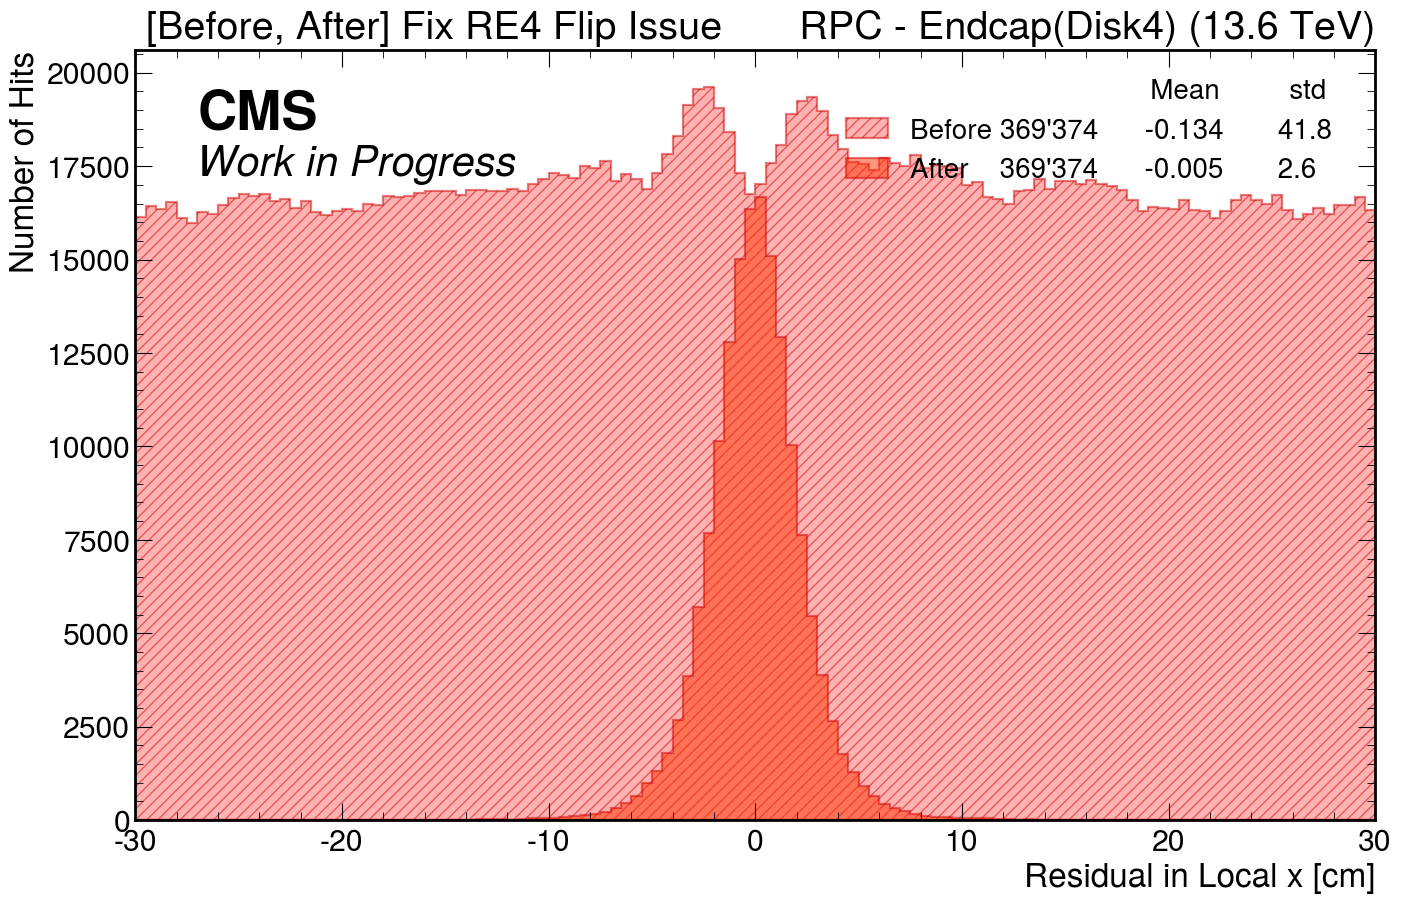

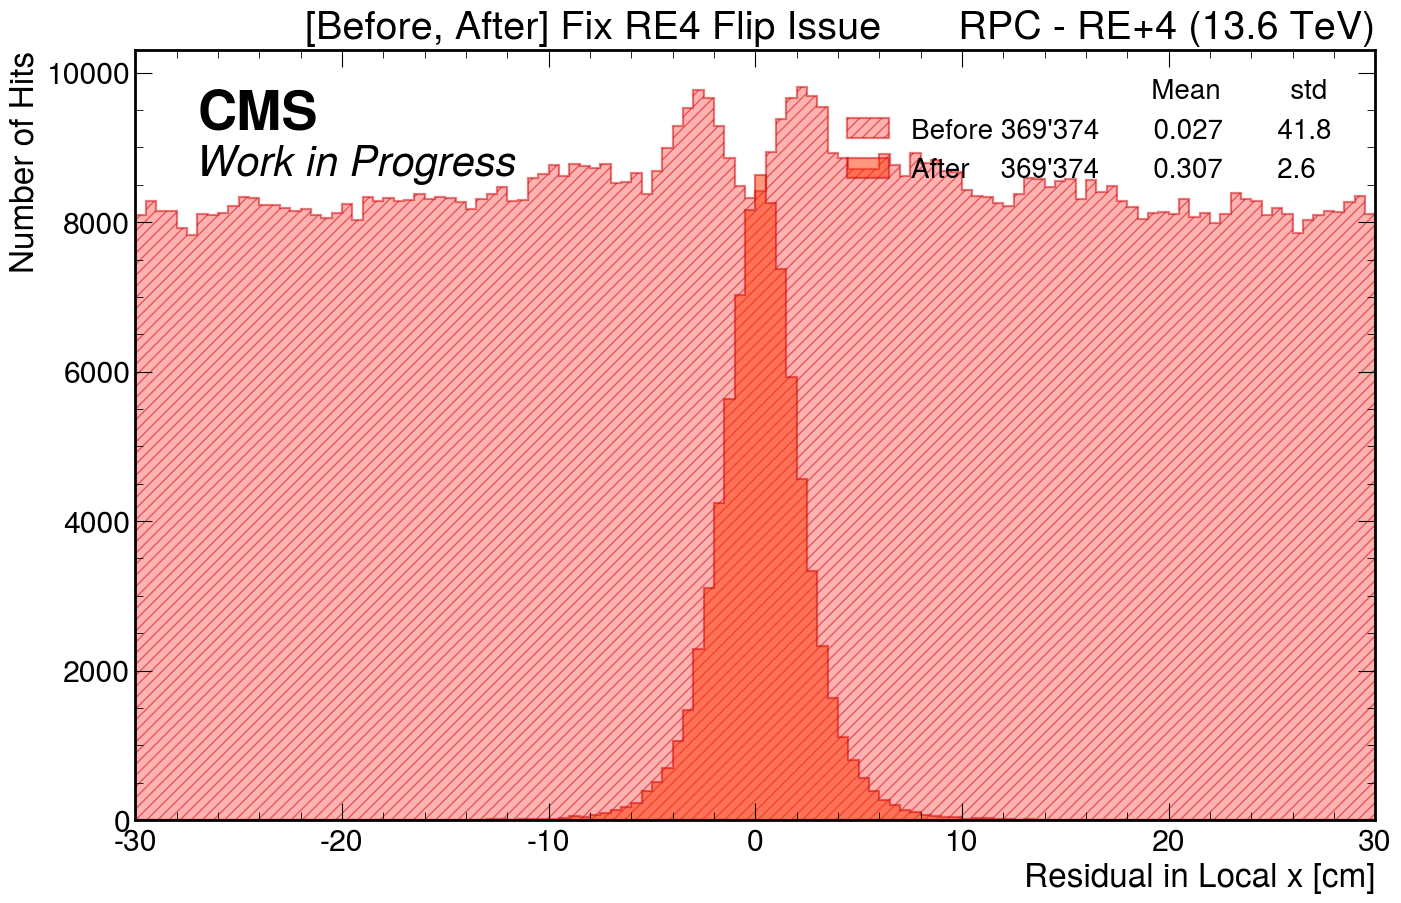

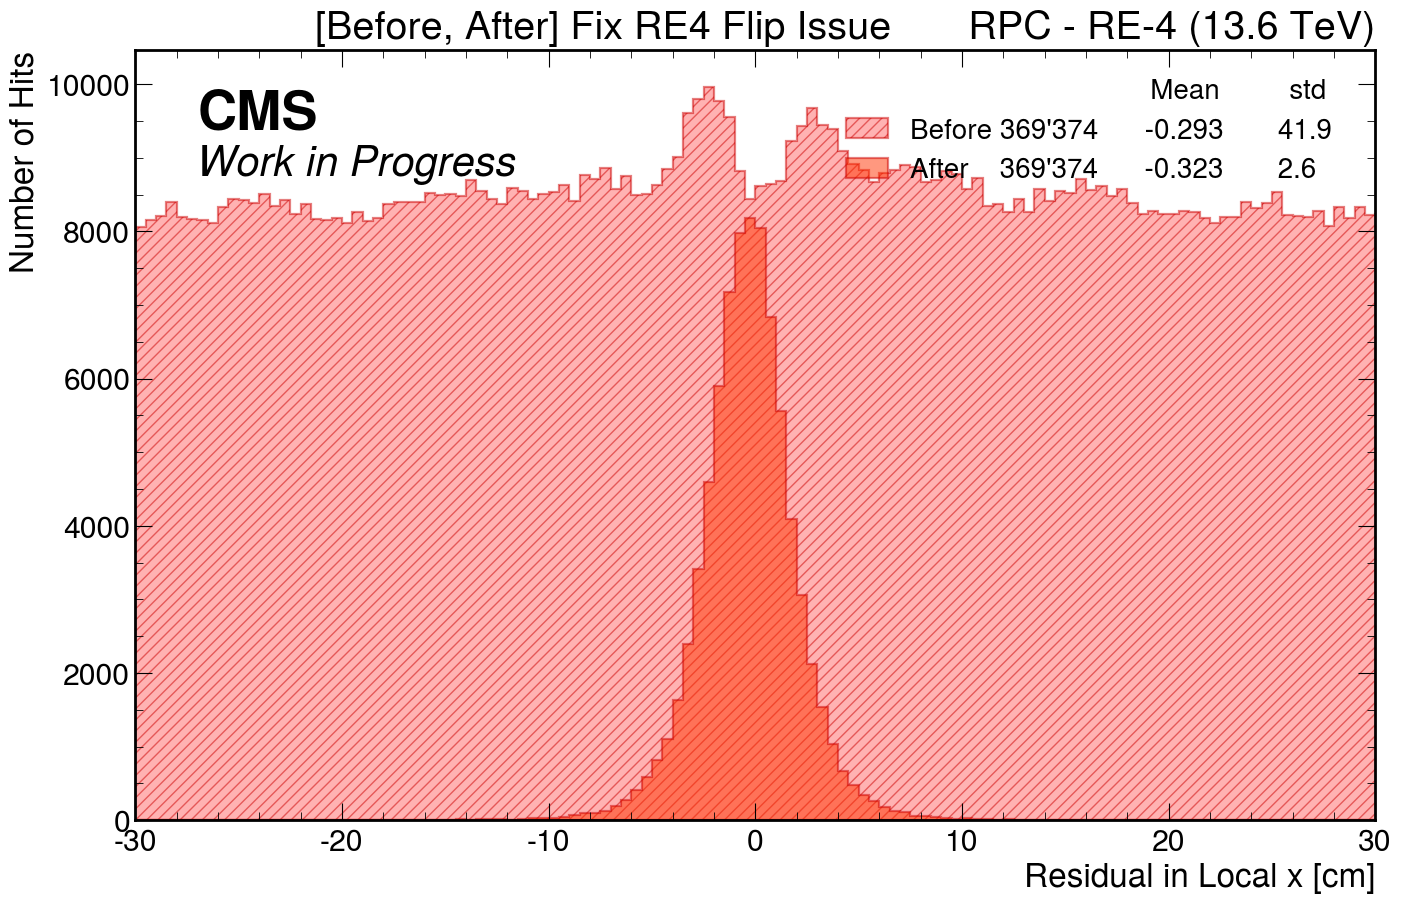

In [7]:
######################################
## Plotting Residual_X Distribution
######################################
mh.style.use(mh.styles.CMS)
label = "Work in Progress"
com = 13.6
regions = [
    'disk4', 'RE+4', 'RE-4',
]
region_labels = [
    'Endcap(Disk4)', 'RE+4', 'RE-4',
]
facecolors = [
    ("#FF6666", "#FF3300"), ("#FF6666", "#FF3300"), ("#FF6666", "#FF3300")
]
edgecolors = [
    "#CC0000", "#CC0000", "#CC0000"
]

for idx in range(len(regions)):
    fig, ax = plt.subplots(figsize=(16, 10))
    mh.cms.label(ax=ax, data=True, label=label, com=com, year=f"[Before, After] Fix RE4 Flip Issue       RPC - {region_labels[idx]}", fontsize=30, loc=2)
    ax.set_xlabel('Residual in Local x [cm]', fontsize=24)
    ax.set_ylabel('Number of Hits', fontsize=24)
    ax.set_xlim(-30, 30)
    ax.plot(np.NaN, np.NaN, '-', color="None", label="                               Mean         std")

    ax = plot_residual_x_hist(
        data = data_before_run_369374,
        region = regions[idx],
        ax = ax,
        facecolor= facecolors[idx][0],
        edgecolor = edgecolors[idx],
        data_legend = "Before 369'374",
        hatch = "///",
    )

    ax = plot_residual_x_hist(
        data = data_after_run_369374,
        region = regions[idx],
        ax = ax,
        facecolor = facecolors[idx][1],
        edgecolor = edgecolors[idx],
        data_legend = "After    369'374",
        hatch = None
    )

    ax.legend(fontsize="20", loc='upper right')

    output_dir = working_dir / 'plotting' / 'Hist1D' / 'hit-residual_x'

    if not output_dir.exists():
        output_dir.mkdir(parents=True)

    fig.savefig(output_dir / f"RE4Flip-{regions[idx]}.png")

/tmp/ipykernel_1094512/4032935104.py:56: UserWarning: Glyph 9 (	) missing from current font.
  fig.savefig(output_dir / f"RE4Flip-{regions[idx]}-logscale.png")


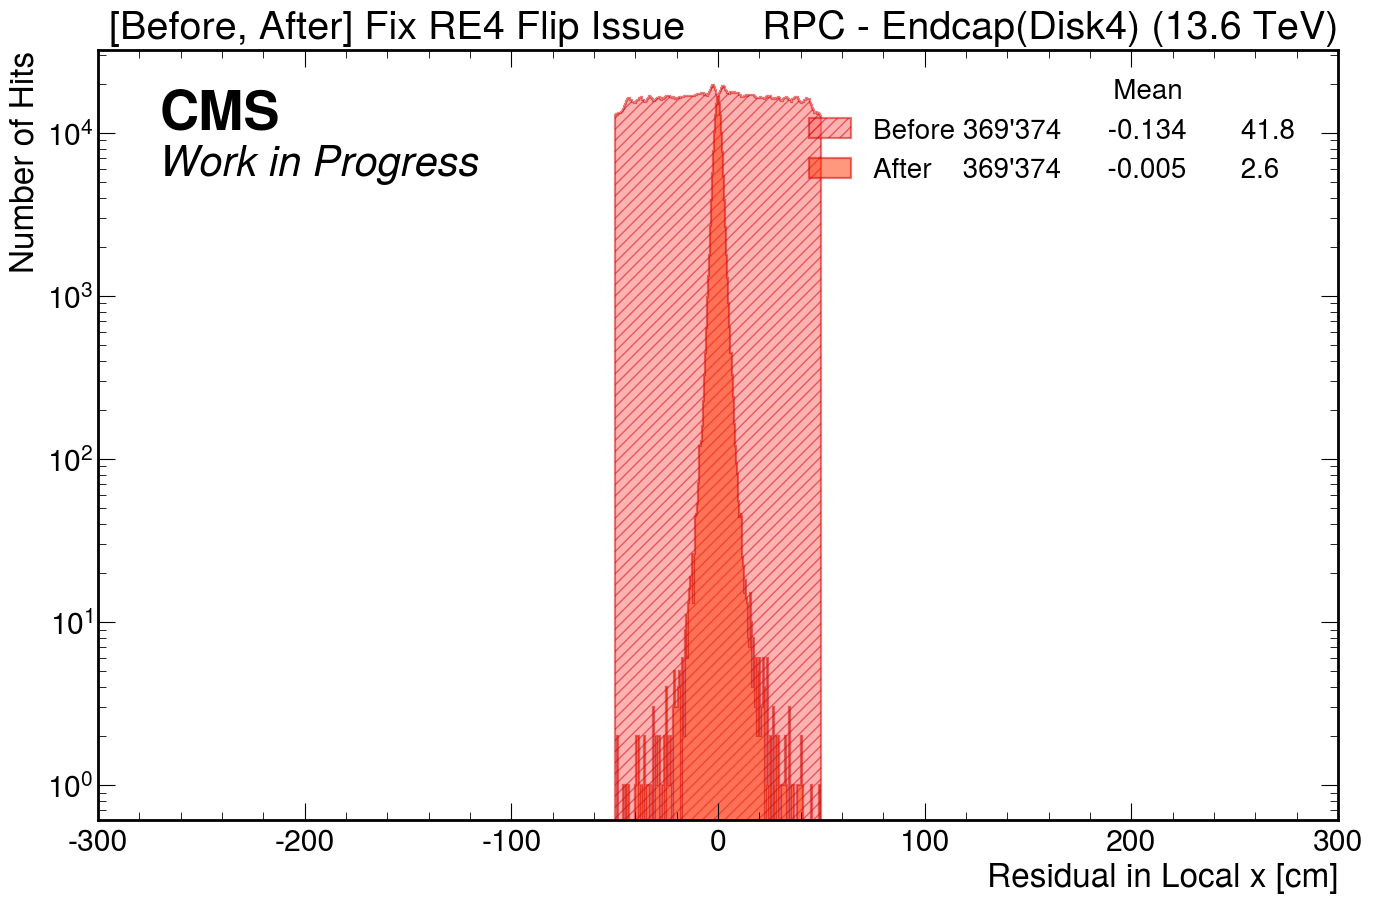

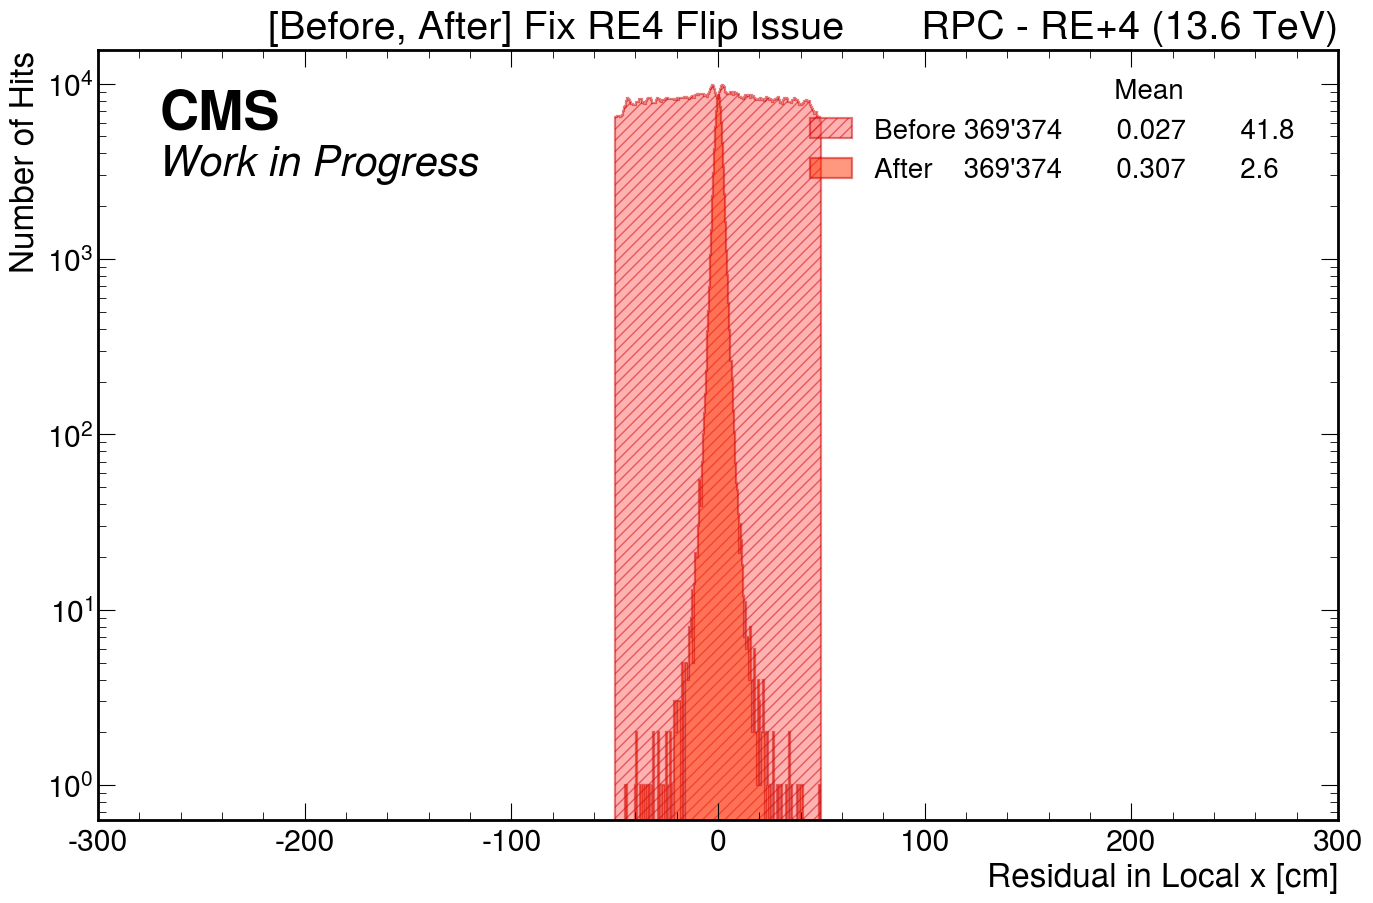

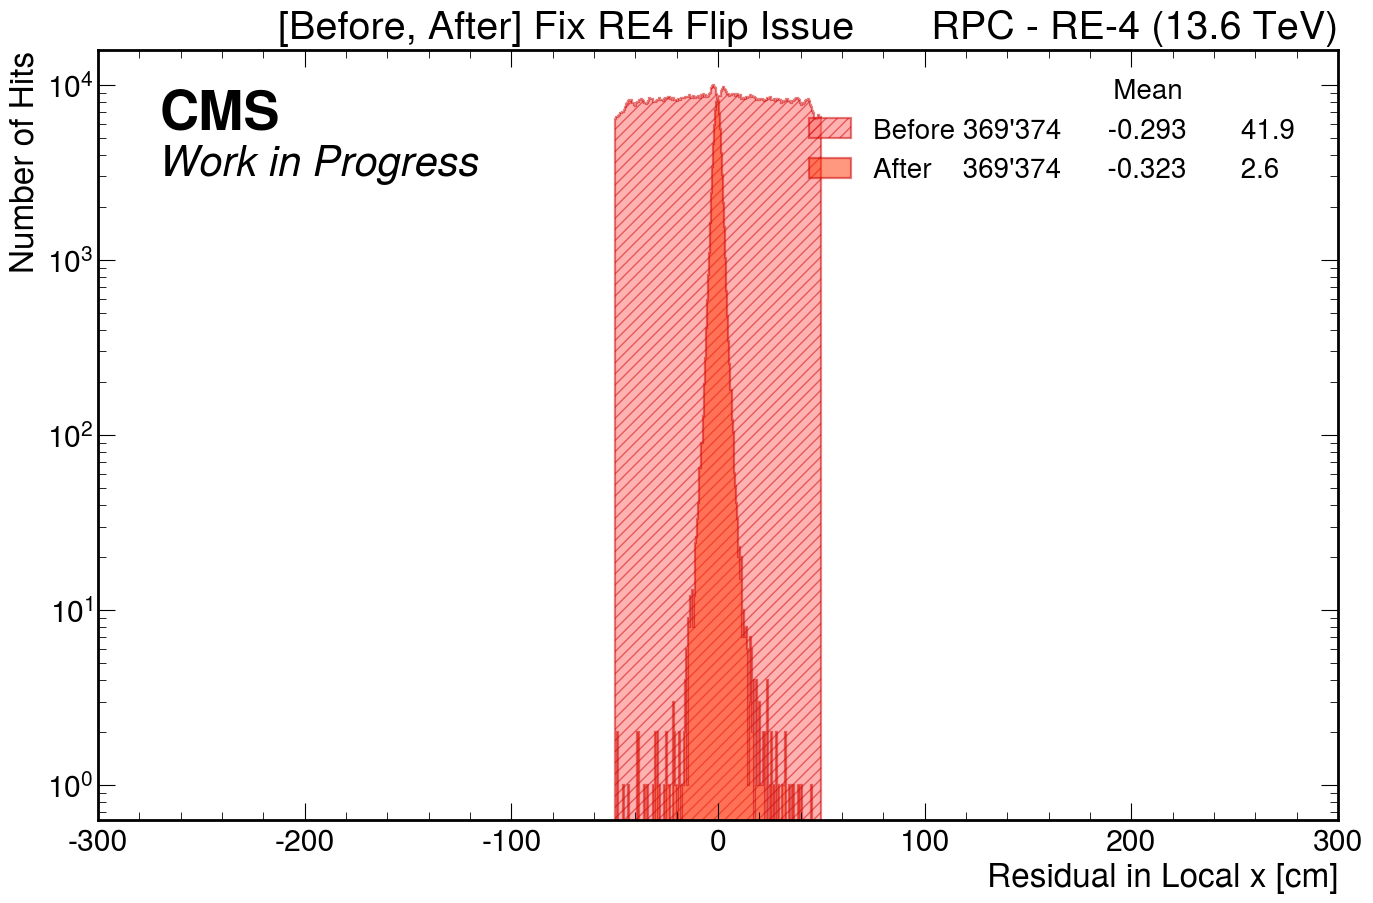

In [8]:
######################################
## Plotting Residual_X - Log Scale Distribution
######################################
mh.style.use(mh.styles.CMS)
label = "Work in Progress"
com = 13.6
regions = [
    'disk4', 'RE+4', 'RE-4',
]
region_labels = [
    'Endcap(Disk4)', 'RE+4', 'RE-4',
]
facecolors = [
    ("#FF6666", "#FF3300"), ("#FF6666", "#FF3300"), ("#FF6666", "#FF3300")
]
edgecolors = [
    "#CC0000", "#CC0000", "#CC0000"
]

for idx in range(len(regions)):
    fig, ax = plt.subplots(figsize=(16, 10))
    mh.cms.label(ax=ax, data=True, label=label, com=com, year=f"[Before, After] Fix RE4 Flip Issue       RPC - {region_labels[idx]}", fontsize=30, loc=2)
    ax.set_xlabel('Residual in Local x [cm]', fontsize=24)
    ax.set_ylabel('Number of Hits', fontsize=24)
    ax.set_xlim(-300, 300)
    ax.set_yscale('log')
    ax.plot(np.NaN, np.NaN, '-', color="None", label="                               Mean")

    ax = plot_residual_x_hist(
        data = data_before_run_369374,
        region = regions[idx],
        ax = ax,
        facecolor= facecolors[idx][0],
        edgecolor = edgecolors[idx],
        data_legend = "Before 369'374",
        hatch = "///",
    )

    ax = plot_residual_x_hist(
        data = data_after_run_369374,
        region = regions[idx],
        ax = ax,
        facecolor = facecolors[idx][1],
        edgecolor = edgecolors[idx],
        data_legend = "After    369'374",
        hatch = None
    )

    ax.legend(fontsize="20", loc='upper right')

    output_dir = working_dir / 'plotting' / 'Hist1D' / 'hit-residual_x-logscale'

    if not output_dir.exists():
        output_dir.mkdir(parents=True)

    fig.savefig(output_dir / f"RE4Flip-{regions[idx]}-logscale.png")